In [1]:
from pinecone import Pinecone
from pinecone import ServerlessSpec
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

True

In [2]:
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))

# 初始化 dense DB

In [24]:
index_name = "museum-ai-dense"
if not pc.has_index(index_name):
    pc.create_index(index_name, 
                    dimension=512, 
                    metric="cosine", 
                    vector_type="dense",
                    spec=ServerlessSpec(
                        cloud="aws",
                        region="us-east-1"
                    ),
                )
    
dense_db = pc.Index(index_name)

In [25]:
import json
import itertools

def setup_dense_db(file_path, namespace="umag"):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    vectors = []
    for section_id, section in data.items():
        for chunk in section:
            if chunk["type"] == "text":
                vectors.append({
                    "id": chunk["id"],
                    "values": chunk["dense_embeddings"],
                    "metadata": {
                        "section_id": section_id,
                        "type": chunk["type"],
                        "content": chunk["text"],
                        "page_idx": chunk["page_idx"],
                    }
                })
            else:
                vectors.append({
                    "id": chunk["id"],
                    "values": chunk["dense_embeddings"],
                    "metadata": {
                        "section_id": section_id,
                        "type": chunk["type"],
                        "img_path": chunk["img_path"],
                        "page_idx": chunk["page_idx"],
                    }
                })

    def chunks(iterable, batch_size=200):
        """A helper function to break an iterable into chunks of size batch_size."""
        it = iter(iterable)
        chunk = tuple(itertools.islice(it, batch_size))
        while chunk:
            yield chunk
            chunk = tuple(itertools.islice(it, batch_size))

    for chunk in chunks(vectors, batch_size=200):
        dense_db.upsert(
            vectors=chunk,
            namespace=namespace
        )

    print(f"Inserted {len(vectors)} vectors into the dense index.")

In [8]:
# delete existing data
dense_db.delete(delete_all=True, namespace="umag")

{}

In [11]:
setup_dense_db(r"output\Objectifying_China\embeddings.json")
setup_dense_db(r"output\Pictorial_Silk\embeddings.json")

Inserted 1728 vectors into the dense index.
Inserted 1334 vectors into the dense index.


In [12]:
dense_db.describe_index_stats(namespace="umag")

{'dimension': 512,
 'index_fullness': 0.0,
 'metric': 'cosine',
 'namespaces': {'umag': {'vector_count': 2895}},
 'total_vector_count': 2895,
 'vector_type': 'dense'}

# 初始化 sparse DB

In [ ]:
index_name = "museum-ai-sparse"
if not pc.has_index(index_name):
    pc.create_index(index_name, 
                    dimension=512, 
                    metric="dotproduct", 
                    vector_type="sparse",
                    spec=ServerlessSpec(
                        cloud="aws",
                        region="us-east-1"
                    ),
                )

sparse_db = pc.Index(index_name)

In [ ]:
def setup_sparse_db(file_path, namespace="umag"):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    vectors = []
    for section_id, section in data.items():
        for chunk in section:
            if chunk["type"] != "text":
                continue

            vectors.append({
                "id": chunk["id"],
                "sparse_values": chunk["sparse_embeddings"],
                "metadata": {
                    "section_id": section_id,
                    "type": chunk["type"],
                    "content": chunk["text"],
                    "page_idx": chunk["page_idx"],
                }
            })
        
    def chunks(iterable, batch_size=200):
        """A helper function to break an iterable into chunks of size batch_size."""
        it = iter(iterable)
        chunk = tuple(itertools.islice(it, batch_size))
        while chunk:
            yield chunk
            chunk = tuple(itertools.islice(it, batch_size))


    for chunk in chunks(vectors, batch_size=200):
        sparse_db.upsert(
            vectors=chunk,
            namespace="umag"
        )

    
    print(f"Inserted {len(vectors)} vectors into the sparse index.")
    sparse_db.describe_index_stats(namespace="umag")

In [ ]:
# delete existing vectors
# sparse_db.delete(delete_all=True, namespace="umag")

{}

In [17]:
setup_sparse_db(r"output\Objectifying_China\embeddings.json")
setup_sparse_db(r"output\Pictorial_Silk\embeddings.json")

Inserted 1705 vectors into the sparse index.
Inserted 1317 vectors into the sparse index.


# 搜索函数

In [18]:
from transformers import AutoProcessor, AutoModel
import torch

MODEL_NAME = "BAAI/BGE-VL-base" # or "BAAI/BGE-VL-large"

device = "cuda" if torch.cuda.is_available() else "cpu"
dense_model = AutoModel.from_pretrained(MODEL_NAME, trust_remote_code=True).to(device) # You must set trust_remote_code=True
dense_model_processor = AutoProcessor.from_pretrained(MODEL_NAME, trust_remote_code=True)
dense_model.eval()

d:\softwares\miniconda3\envs\aiha\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [19]:
from PIL import Image

def get_text_embeddings(texts: list[str]) -> list:
    if not texts:
        return []
    inputs = dense_model_processor(text=texts, return_tensors="pt", truncation=True, padding=True).to(device)
    return dense_model.get_text_features(**inputs).cpu()

def get_image_embeddings(image_paths: list[str]) -> list:
    if not image_paths:
        return []
    images = [Image.open(image_path).convert("RGB") for image_path in image_paths]
    inputs = dense_model_processor(images=images, return_tensors="pt").to(device)
    return dense_model.get_image_features(**inputs).cpu()

In [20]:
# Load model directly
import torch
from transformers import AutoTokenizer, AutoModelForMaskedLM

sparse_model_tokenizer = AutoTokenizer.from_pretrained("naver/splade-v3")
sparse_model = AutoModelForMaskedLM.from_pretrained("naver/splade-v3").to(device)

In [21]:
def get_sparse_embeddings(texts: list[str]):
    if not texts:
        return []
    tokens = sparse_model_tokenizer(texts, return_tensors="pt", truncation=True, padding=True).to(device)
    outputs = sparse_model(**tokens)
    sparse_embedding = torch.max(torch.log(1 + torch.relu(outputs.logits)) * tokens.attention_mask.unsqueeze(-1), dim=1)[0].detach().cpu()
    
    # convert to pinecone sparse format
    res = []
    for i in range(len(sparse_embedding)):
        indices = sparse_embedding[i].nonzero().squeeze().tolist()
        values = sparse_embedding[i, indices].tolist()
        res.append({"indices": indices, "values": values})
    return res

In [22]:
query = "tell me something about Jug with Portuguese arms."

In [23]:
dense_results = dense_db.query(
    namespace="umag",
    top_k=10,
    include_values=False,
    include_metadata=True,
    vector=get_text_embeddings([query])[0].tolist()
)

In [27]:
sparse_results = sparse_db.query(
    namespace="umag",
    top_k=5,
    include_values=False,
    include_metadata=True,
    sparse_vector=get_sparse_embeddings([query])[0]
)

In [28]:
sparse_results

{'matches': [{'id': 'mzj11abw',
              'metadata': {'content': 'Jug with Portuguese arms.',
                           'page_idx': 8.0,
                           'section_id': 'y91cel1n',
                           'type': 'text'},
              'score': 22.8160553,
              'values': []},
             {'id': '2efc0bd5',
              'metadata': {'content': 'That space was painted with a coat of '
                                      'arms in red, orange, and green enamels.',
                           'page_idx': 23.0,
                           'section_id': 'npa2l1xa',
                           'type': 'text'},
              'score': 10.3820896,
              'values': []},
             {'id': 'be728bc7',
              'metadata': {'content': 'A porcelain ewer had the seal of '
                                      'Portugal painted upside down.',
                           'page_idx': 8.0,
                           'section_id': 'y91cel1n',
                        

In [29]:
def merge_chunks(h1, h2):
    """Get the unique hits from two search results and return them as single array of {'_id', 'chunk_text'} dicts, printing each dict on a new line."""
    # Deduplicate by _id
    deduped_hits = {hit['id']: hit for hit in h1['matches'] + h2['matches']}.values()
    # Sort by _score descending
    sorted_hits = sorted(deduped_hits, key=lambda x: x['score'], reverse=True)
    # Transform to format for reranking
    result = [{'id': hit['id'], 'chunk_text': hit['metadata']['content']} for hit in sorted_hits]
    return result

def search_with_text(query: str):
    dense_results = dense_db.query(
        namespace="umag",
        top_k=5,
        include_values=True,
        include_metadata=True,
        vector=get_text_embeddings([query])[0].tolist()
    )

    sparse_results = sparse_db.query(
        namespace="umag",
        top_k=5,
        include_values=True,
        include_metadata=True,
        sparse_vector=get_sparse_embeddings([query])[0]
    )

    merged_results = merge_chunks(sparse_results, dense_results)

    return merged_results


def search_with_image(image_path: str):
    dense_results = dense_db.query(
        namespace="umag",
        top_k=20,
        include_values=False,
        include_metadata=True,
        vector=get_image_embeddings([image_path])[0].tolist()
    )

    # sparse_results = sparse_db.query(
    #     namespace="umag",
    #     top_k=5,
    #     include_values=True,
    #     include_metadata=True,
    #     sparse_vector=get_sparse_vector(get_sparse_embeddings([query])[0])
    # )

    # merged_results = merge_chunks(sparse_results, dense_results)

    return dense_results

In [ ]:
merge_chunks(sparse_results, dense_results)

In [44]:
search_with_text(query)

[{'id': 'd2k7v4zs',
  'chunk_text': 'Centuries before the flowering of blue-and-white wares in the fourteenth century, large kiln sites in northern and southern China were producing glazed porcelain and stoneware in various shades of blue, green and white, which were adorned with elegant incised decoration. Some of the most famous of these include qingbai (‘green-white’), a translucent porcelain with a bluish-green glaze produced at kiln complexes in Jingdezhen and Jizhou, and celadon, a type of porcelain or stoneware with an olive-green glaze that takes its name from a character with a distinctive outfit in L’Astrée, a seventeenthcentury French comedy. Similar in colour to valuable jade, these ceramics were among the most highly regarded in China—particularly celadon from the Longquan kilns in Lishui, Zhejiang province, which supplied the Southern Song court after the collapse of the northern dynasty in 1127. Today, some scholars prefer the term ‘greenware’ for these ceramics to avoid

In [30]:
results = search_with_image(r"output\Objectifying_China\auto\images\a183274b5c151671e2f87a6108aaa7a4e6db3a1fe522c783ab8ce3dbe02e6aa7.jpg")

In [31]:
results

{'matches': [{'id': 'zwn16upb',
              'metadata': {'img_path': 'd:\\HKU\\Inno Wing RA\\UBC '
                                       'Exchange\\code\\output\\Objectifying_China\\preprocessed\\../auto/images/b64bf3ee92f3ee8b4f0d10d876877906b2245602c6a53adba92a12a25510832a.jpg',
                           'page_idx': 22.0,
                           'section_id': 'tyv65jod',
                           'type': 'image'},
              'score': 0.946162641,
              'values': []},
             {'id': 'q4ucb384',
              'metadata': {'img_path': 'd:\\HKU\\Inno Wing RA\\UBC '
                                       'Exchange\\code\\output\\Objectifying_China\\preprocessed\\../auto/images/8de5dace2ecee0003b52bb549a984617687e4174a9a158dbf53b92921d9067bd.jpg',
                           'page_idx': 14.0,
                           'section_id': 'nbk7qpwp',
                           'type': 'image'},
              'score': 0.912250519,
              'values': []},
             {

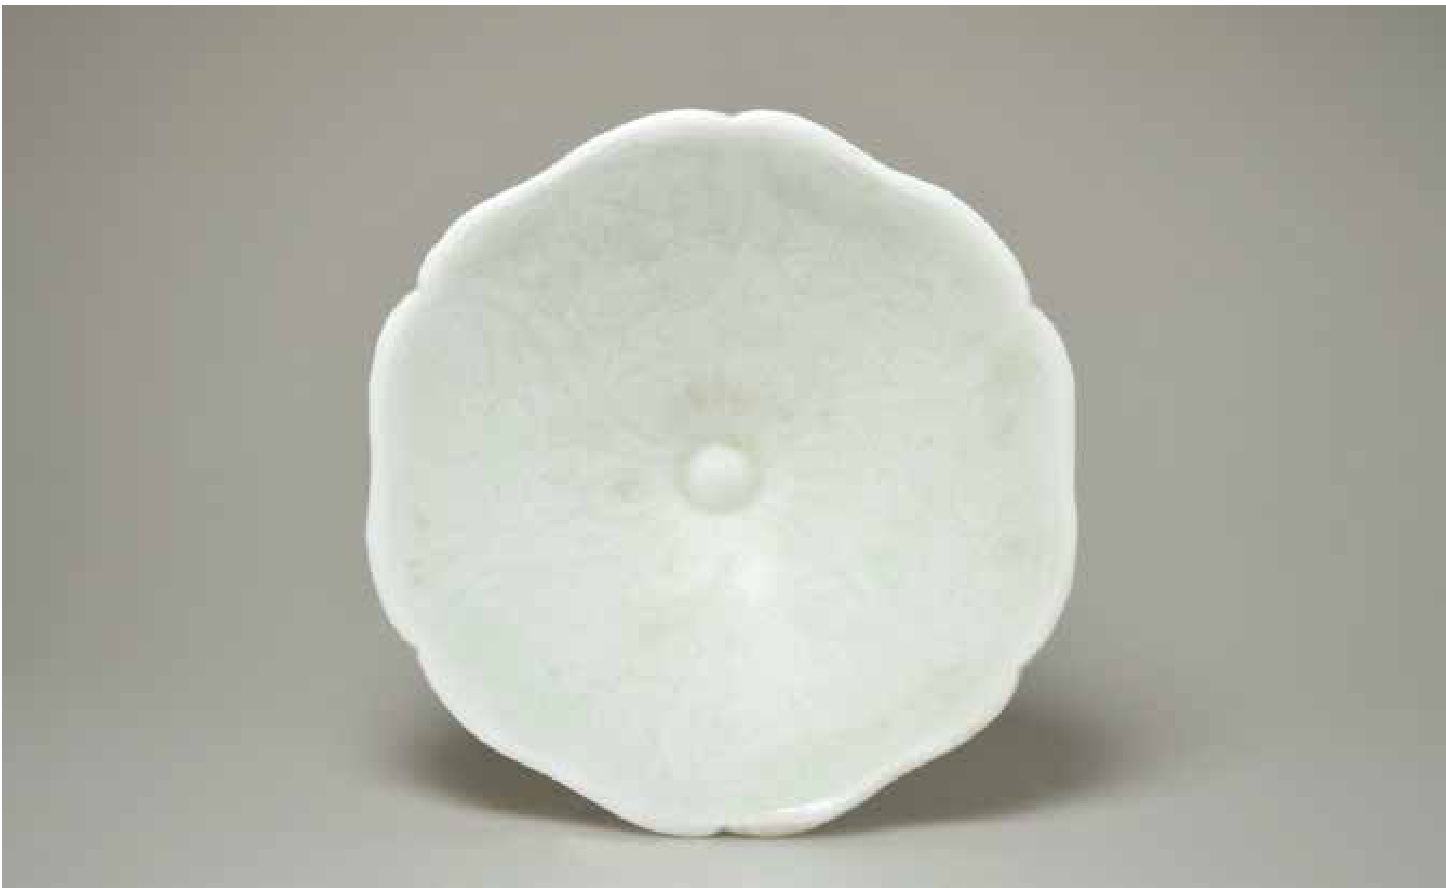

In [75]:
Image.open(results['matches'][19]['metadata']['img_path'])